A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types. These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.

Why Use a Structured Output Agent?
Controlled Responses: Ensures that the outputs follow a specific format, reducing ambiguity.
Data Validation: Useful when you want the model output to fit predefined structures, like for APIs or database entries.
Automation: Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [2]:
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=gemini_api_key)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",api_key=gemini_api_key)

In [3]:
llm.invoke("who is mr.360").content

'"Mr. 360" is a nickname most famously associated with **AB de Villiers**, a former South African cricketer.\n\nHe earned this nickname because of his incredible ability to hit the ball to all parts of the ground, seemingly 360 degrees around the wicket. He was known for his innovative and unorthodox shots, making him one of the most exciting and unpredictable batsmen to watch.'

In [4]:
tavily_tool = TavilySearchResults()

In [5]:
@tool
def get_city_details(prompt: str):
     "Should do a web search to find the required city details"
     response = tavily_tool.invoke(prompt)
     return response

In [6]:
tools = [get_city_details]
model_with_tools = llm.bind_tools(tools)

In [7]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")
    city_description: str

In [8]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    final_response: CityDetails

In [9]:
model_with_structured_output = llm.with_structured_output(CityDetails)

In [10]:
def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [11]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else: 
        return "continue"

In [12]:
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

In [13]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

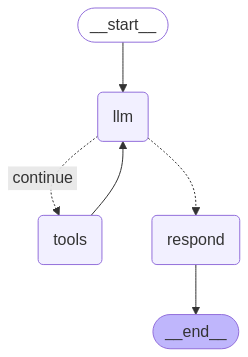

In [14]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for Mehsana?")]})['final_response']

 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for Mehsana?', additional_kwargs={}, response_metadata={}, id='02a89eb5-368b-413f-9425-e0ffa8992aeb')]}
this is 02 response from call model  content='' additional_kwargs={'function_call': {'name': 'get_city_details', 'arguments': '{"prompt": "Mehsana city details"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-82ec46a2-94d4-4ca7-8173-af9c180c9560-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Mehsana city details'}, 'id': 'b5cd5fc2-4289-4bb1-a664-01c3eaecb03b', 'type': 'tool_call'}] usage_metadata={'input_tokens': 29, 'output_tokens': 11, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}}
 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for Mehsana?', additional_kwargs={}, response_metadata={}, id='02a89eb5-368b-413f

In [16]:
answer

CityDetails(state_name='Gujarat', state_capital='Gandhinagar', country_name='India', country_capital='New Delhi', city_description="Mehsana is a city in the state of Gujarat, India, and is the administrative headquarters of the Mehsana district. It was established in the 14th century and was under the Gaekwads of Baroda State from the 18th century until India's independence in 1947. The major industries in the city are dairy, oil, and natural gas. The city has a population of 184,991 as of 2011, and the district has a population of over 2 million.")